# Campervan Projekt

## Libraries and settings

In [163]:
# Libraries
import os
import re
import sqlite3
import fnmatch
import pprint
import requests
import numpy as np
import pandas as pd

import json
import urllib
import folium
import platform

import geopandas as gpd
from IPython.display import clear_output

from shapely.geometry import Polygon

import matplotlib.patches as patches
from matplotlib import pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Function to close a sqlite db-connection
def check_conn(conn):
     try:
        conn.cursor()
        return True
     except Exception as ex:
        return False


print(os.getcwd())

/workspaces/project_Autoscout_Coding_Pros/Project_Campers


## Import data

In [164]:
# Read data
df_orig = pd.read_csv("./data/Autoscout24_Camper.csv", sep=",", encoding='utf-8')

# Show column names from df_orig
print(df_orig.columns)

# define the columns to keep
colums = ['web-scraper-order',
        'description_raw',
        'price_raw', 
        'mileage_raw',
       'fuel_type_raw', 
       'location_raw']

# keep only the columns we are interested in
df = df_orig[colums]

# Show first records of data frame
df.head()


Index(['web-scraper-order', 'web-scraper-start-url', 'autoscout24',
       'autoscout24-href', 'description_raw', 'price_raw', 'mileage_raw',
       'fuel_type_raw', 'location_raw'],
      dtype='object')


,web-scraper-order,description_raw,price_raw,mileage_raw,fuel_type_raw,location_raw
0,1733470796-1,MERCEDES-BENZ Camper,CHF 15'900.–,265'000 km,Diesel,"Mittelstrasse 38, 3613 Steffisburg"
1,1733470799-2,CARADO I 449 Édition 15 Fiat Capron 169L/1449,CHF 71'900.–,14'000 km,Diesel,"Zone industrielle Les Portettes 2c, 1312 Eclépens"
2,1733470801-3,DETHLEFFS Fiat Ducato,CHF 37'800.–,90'000 km,Diesel,"Rte du St-Bernard 8, 1937 Orsières"
3,1733470805-4,FIAT Euro Master Wohnmobil,CHF 19'900.–,187'236 km,Diesel,"Badenerstrasse 84, 8952 Schlieren"
4,1733470807-5,VW T6.1 California 2.0 TDI Ocean Edition Liber...,CHF 84'500.–,16'500 km,Diesel,8852 Altendorf


### Count numbre of rows and columns in the dateframe

In [165]:
# Dimension (rows, columns)
print('Dimension:', df.shape)

# Number of rows
print('Number of rows:', df.shape[0])

# Number of columns
print('Number of columns:', df.shape[1])

Dimension: (1587, 6)
Number of rows: 1587
Number of columns: 6


### Get Data types from Web scraping

In [166]:
# Get data types (note that in pandas, a string is referred to as 'object')
df.dtypes

web-scraper-order    object
description_raw      object
price_raw            object
mileage_raw          object
fuel_type_raw        object
location_raw         object
dtype: object

#### Extract and save relevant information from raw data using regular expressions (regex)

### Extract Price

In [167]:
# Extract values from 'price_raw' column
price = []
for i in df['price_raw']:
    d1 = re.findall(r'[0-9]+', str(i))
    try:
        d2 = ''.join(d1).replace("'", "").replace("CHF", "").replace(".-", "").strip()
    except:
        d2 = None
    price.append(d2)

# Save as new variable in the pandas data frame
df['price'] = pd.Series(price, dtype="int")
    
# Print first 5 values
print(df[['price_raw', 'price']].head(5))

      price_raw  price
0  CHF 15'900.–  15900
1  CHF 71'900.–  71900
2  CHF 37'800.–  37800
3  CHF 19'900.–  19900
4  CHF 84'500.–  84500


In [168]:
df.head()

,web-scraper-order,description_raw,price_raw,mileage_raw,fuel_type_raw,location_raw,price
0,1733470796-1,MERCEDES-BENZ Camper,CHF 15'900.–,265'000 km,Diesel,"Mittelstrasse 38, 3613 Steffisburg",15900
1,1733470799-2,CARADO I 449 Édition 15 Fiat Capron 169L/1449,CHF 71'900.–,14'000 km,Diesel,"Zone industrielle Les Portettes 2c, 1312 Eclépens",71900
2,1733470801-3,DETHLEFFS Fiat Ducato,CHF 37'800.–,90'000 km,Diesel,"Rte du St-Bernard 8, 1937 Orsières",37800
3,1733470805-4,FIAT Euro Master Wohnmobil,CHF 19'900.–,187'236 km,Diesel,"Badenerstrasse 84, 8952 Schlieren",19900
4,1733470807-5,VW T6.1 California 2.0 TDI Ocean Edition Liber...,CHF 84'500.–,16'500 km,Diesel,8852 Altendorf,84500


### Extract Mileage

In [169]:
# Extract values from 'mileage_raw' column
mileage = []
for i in df['mileage_raw']:
    d1 = re.findall(r'[0-9]+', str(i))
    try:
        d2 = ''.join(d1).replace("'", "").replace("km", "").replace(".-", "").strip()
    except:
        d2 = None
    mileage.append(d2)

# Save as new variable in the pandas data frame
df['mileage'] = pd.Series(mileage, dtype="int")
    
# Print first 5 values
print(df[['mileage_raw','mileage']].head(5))

  mileage_raw  mileage
0  265'000 km   265000
1   14'000 km    14000
2   90'000 km    90000
3  187'236 km   187236
4   16'500 km    16500


In [170]:
df.dtypes

web-scraper-order    object
description_raw      object
price_raw            object
mileage_raw          object
fuel_type_raw        object
location_raw         object
price                 int64
mileage               int64
dtype: object

### Fuel Type without Outliers

In [171]:
#count frequency of values in column 'fuel_type_raw'
df['fuel_type_raw'].value_counts()

fuel_type_raw
Diesel     1453
Benzin       72
-            61
Elektro       1
Name: count, dtype: int64

In [172]:
# Filter für Diesel und Benzin
df = df[(df['fuel_type_raw'] == 'Diesel') | (df['fuel_type_raw'] == 'Benzin')]

count = df['fuel_type_raw'].value_counts()
print(count)

fuel_type_raw
Diesel    1453
Benzin      72
Name: count, dtype: int64


### Piechart for fueltype

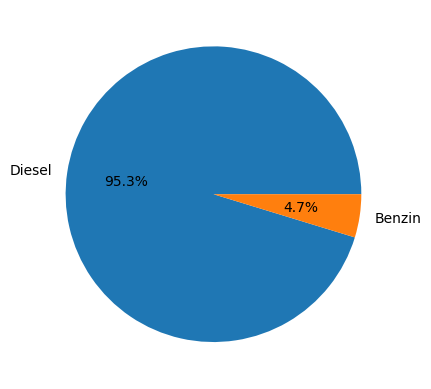

In [173]:
# get a pie chart for the fuel types
fig, ax = plt.subplots()
ax.pie(count, labels=count.index, autopct='%1.1f%%')
plt.show()


### Fuel type to Dummy

In [174]:
# One-Hot-Encoding für die Spalte 'fuel_type_raw'
df_encoded = pd.get_dummies(df['fuel_type_raw'], prefix='fuel_type', drop_first=True)

# Konvertiere boolesche Werte in 0 und 1 (falls vorhanden)
bool_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

# Füge nur die neuen One-Hot-encoded Spalten dem ursprünglichen DataFrame hinzu
df = df.join(df_encoded)

# Überprüfe das Ergebnis
df.head()

,web-scraper-order,description_raw,price_raw,mileage_raw,fuel_type_raw,location_raw,price,mileage,fuel_type_Diesel
0,1733470796-1,MERCEDES-BENZ Camper,CHF 15'900.–,265'000 km,Diesel,"Mittelstrasse 38, 3613 Steffisburg",15900,265000,1
1,1733470799-2,CARADO I 449 Édition 15 Fiat Capron 169L/1449,CHF 71'900.–,14'000 km,Diesel,"Zone industrielle Les Portettes 2c, 1312 Eclépens",71900,14000,1
2,1733470801-3,DETHLEFFS Fiat Ducato,CHF 37'800.–,90'000 km,Diesel,"Rte du St-Bernard 8, 1937 Orsières",37800,90000,1
3,1733470805-4,FIAT Euro Master Wohnmobil,CHF 19'900.–,187'236 km,Diesel,"Badenerstrasse 84, 8952 Schlieren",19900,187236,1
4,1733470807-5,VW T6.1 California 2.0 TDI Ocean Edition Liber...,CHF 84'500.–,16'500 km,Diesel,8852 Altendorf,84500,16500,1


## Geocoding

In [190]:
# Define base url
base_url= "https://api3.geo.admin.ch/rest/services/api/SearchServer?"

# Geocode list of adresses
geolocation = []
n = 1
for i in df['location_raw'].astype(str):
    
    print('Geocoding address', 
          n, 
          'out of', 
          len(df['location_raw']), 
          ':', 
          i)
    n=n+1
    clear_output(wait=True)
    
    try:
        # Set up search parameters - address, origins and type
        parameters = {"searchText": i,
                      "origins": "address",
                      "type": "locations",
                     }

        # Server request
        r = requests.get(f"{base_url}{urllib.parse.urlencode(parameters)}")

        # Get data
        data = json.loads(r.content)

        # Take first server response, convert to df with relevant infos
        df_loc = pd.DataFrame.from_dict(list(data.values())[0][0], 
                                        orient='columns')
        geolocation.append(df_loc.iloc[[5,6],0].astype(float))
    
    except:
        geolocation.append(pd.Series(data={'lat': None, 'lon': None}))
        
# Write lat and lon to df
df_loc = pd.DataFrame(geolocation, 
                      columns=("lat", "lon"), 
                      index=range(len(df['location_raw'])))
df['lat'] = df_loc['lat']
df['lon'] = df_loc['lon']
df.head(5)

,web-scraper-order,description_raw,price_raw,mileage_raw,fuel_type_raw,location_raw,price,mileage,fuel_type_Diesel,price_cat,lat,lon
0,1733470796-1,MERCEDES-BENZ CAMPER,CHF 15'900.–,265'000 km,Diesel,"MITTELSTRASSE 38, 3613 STEFFISBURG",15900,265000,1,0 - 19999,46.767906,7.615882
1,1733470799-2,CARADO I 449 ÉDITION 15 FIAT CAPRON 169L/1449,CHF 71'900.–,14'000 km,Diesel,"ZONE INDUSTRIELLE LES PORTETTES 2C, 1312 ECLÉPENS",71900,14000,1,50000 - 99999,46.655277,6.553427
2,1733470801-3,DETHLEFFS FIAT DUCATO,CHF 37'800.–,90'000 km,Diesel,"RTE DU ST-BERNARD 8, 1937 ORSIÈRES",37800,90000,1,20000 - 49999,46.035847,7.146043
3,1733470805-4,FIAT EURO MASTER WOHNMOBIL,CHF 19'900.–,187'236 km,Diesel,"BADENERSTRASSE 84, 8952 SCHLIEREN",19900,187236,1,0 - 19999,47.397285,8.434127
4,1733470807-5,VW T6.1 CALIFORNIA 2.0 TDI OCEAN EDITION LIBER...,CHF 84'500.–,16'500 km,Diesel,8852 ALTENDORF,84500,16500,1,50000 - 99999,47.169807,8.801252


### Count and identify missing values

In [191]:
# Count missing values
print(pd.isna(df).sum())

# Identify rows with missing values
df[df.isna().any(axis=1)].head()

web-scraper-order      0
description_raw        0
price_raw              0
mileage_raw            0
fuel_type_raw          0
location_raw           0
price                  0
mileage                0
fuel_type_Diesel       0
price_cat              0
lat                  234
lon                  234
dtype: int64


,web-scraper-order,description_raw,price_raw,mileage_raw,fuel_type_raw,location_raw,price,mileage,fuel_type_Diesel,price_cat,lat,lon
10,1733470822-11,CONCORDE CREDO A 825L,CHF 105'000.–,44'000 km,Diesel,"HAUSACKERSTRASSE 2, 4853 MURGENTHAL",105000,44000,1,100000 - 199999,NaN,NaN
13,1733470832-14,VW T5 CALIFORNIA 2.0 TDI COMFORTLINE,CHF 39'900.–,117'000 km,Diesel,"VIA ALA CAMPAGNA 4, 6593 CADENAZZO",39900,117000,1,20000 - 49999,NaN,NaN
15,1733470837-16,MERCEDES-BENZ HYMER,CHF 5'900.–,148'115 km,Benzin,"ZÜRICH-BERN-STRASSE 58, 3429 HÖCHSTETTEN",5900,148115,0,0 - 19999,NaN,NaN
18,1733470844-19,MERCEDES-BENZ MARCO POLO 300 D 4M A,CHF 84'500.–,29'000 km,Diesel,"VIA MONDARI 7, 6512 GIUBIASCO - RIAZZINO",84500,29000,1,50000 - 99999,NaN,NaN
23,1733470860-26,MERCEDES-BENZ MARCO POLO HORIZON 250 D 4MATIC ...,CHF 55'900.–,79'249 km,Diesel,"BRÜHLMATTEN 7 , ( INDUSTRIEZONE BRÜHL ), 4800 ...",55900,79249,1,50000 - 99999,NaN,NaN


### Drop rows with missing values

In [194]:
# Drop rows with missing values
df = df.dropna()

df.shape

(1291, 12)

## Count and identify duplicated values (if any)

In [195]:
# Count duplicated values
print(df.duplicated().sum())

# Identify rows with duplicated values, e.g.:
df[df[['web-scraper-order', 'description_raw', 'price_raw', 'mileage_raw' ]].duplicated()]

0


,web-scraper-order,description_raw,price_raw,mileage_raw,fuel_type_raw,location_raw,price,mileage,fuel_type_Diesel,price_cat,lat,lon


## Save to Datafile

In [196]:
df.to_csv('./data/Camper_data_prepared.csv', 
          sep=",", 
          encoding='utf-8',
          index=False)

In [197]:
df.describe()

,price,mileage,fuel_type_Diesel,lat,lon
count,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000
mean,57615.120837,72920.701007,0.953524,47.161129,8.162730
std,40053.028090,64796.298179,0.210594,0.423597,0.815490
min,900.000000,10000.000000,0.000000,45.899052,6.047384
25%,39499.500000,26208.000000,1.000000,46.940668,7.579732
50%,54900.000000,50000.000000,1.000000,47.255882,8.349366
75%,66998.000000,99810.000000,1.000000,47.458195,8.709936
max,499000.000000,450000.000000,1.000000,47.760983,10.291002


### Plot Map

In [201]:
# Initialisierung der Map
m = folium.Map(location=[47.44, 8.65], zoom_start=10)

# Map settings
#folium.Choropleth(
 #   geo_data=polys,
  #  name='polys',
   # fill_color='greenyellow'
#).add_to(m)

# Add lat/lon of addresses
df_sub = df.dropna()
for i in range(0, len(df_sub)):
    folium.Marker(location=(df_sub.iloc[i]['lat'], 
                            df_sub.iloc[i]['lon']), 
                  popup=df_sub.iloc[i]['location_raw']).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Plot map
m

## Create SQLite Database

In [179]:
# Create a connection to the database
conn = sqlite3.connect('./data/Camper.db')

# Check if the connection was successful
check_conn(conn)

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Show dbs in the directory
flist = fnmatch.filter(os.listdir('.'), '*.db')
for i in flist:
    print(i)

## Create SQL-Table in the database

In [180]:
cursor.execute("DROP TABLE IF EXISTS Camper")

# Create a table
cursor.execute("""CREATE TABLE Camper (
                web_scraper_order TEXT,
                description_raw TEXT,
                price_raw TEXT,
                mileage_raw TEXT,
                location_raw TEXT,
                price INTEGER,
                mileage INTEGER,
                fuel_type_raw TEXT,
                fuel_type_Diesel INTEGER
                )""")

# Commit the changes
conn.commit()

# Read the data from the CSV file
df = pd.read_csv('./data/Camper_data_prepared.csv', 
                 sep=",", 
                 encoding='utf-8')[['web-scraper-order',
                                    'description_raw',
                                    'price_raw', 
                                    'mileage_raw',
                                    'fuel_type_raw', 
                                    'location_raw',
                                    'price', 
                                    'mileage',  
                                    'fuel_type_Diesel']]
print(df.shape)


(1525, 9)


In [181]:
df.head(5)

,web-scraper-order,description_raw,price_raw,mileage_raw,fuel_type_raw,location_raw,price,mileage,fuel_type_Diesel
0,1733470796-1,MERCEDES-BENZ Camper,CHF 15'900.–,265'000 km,Diesel,"Mittelstrasse 38, 3613 Steffisburg",15900,265000,1
1,1733470799-2,CARADO I 449 Édition 15 Fiat Capron 169L/1449,CHF 71'900.–,14'000 km,Diesel,"Zone industrielle Les Portettes 2c, 1312 Eclépens",71900,14000,1
2,1733470801-3,DETHLEFFS Fiat Ducato,CHF 37'800.–,90'000 km,Diesel,"Rte du St-Bernard 8, 1937 Orsières",37800,90000,1
3,1733470805-4,FIAT Euro Master Wohnmobil,CHF 19'900.–,187'236 km,Diesel,"Badenerstrasse 84, 8952 Schlieren",19900,187236,1
4,1733470807-5,VW T6.1 California 2.0 TDI Ocean Edition Liber...,CHF 84'500.–,16'500 km,Diesel,8852 Altendorf,84500,16500,1


## Write data to the SQL-table in data base

In [182]:
df.to_sql(name = 'campervans_table',
          con = conn,
          index = False,
          if_exists = 'replace')

1525

## Query the SQL-table

In [183]:
# Query the SQL-table
cursor.execute('''SELECT *
               FROM campervans_table
               WHERE price <=1000000''')

df = pd.DataFrame(cursor.fetchall(), 
                  columns=['web-scraper-order',
                                    'description_raw',
                                    'price_raw', 
                                    'mileage_raw',
                                    'fuel_type_raw', 
                                    'location_raw',
                                    'price', 
                                    'mileage',  
                                    'fuel_type_Diesel'])
print(df.count())
df.head()

web-scraper-order    1525
description_raw      1525
price_raw            1525
mileage_raw          1525
fuel_type_raw        1525
location_raw         1525
price                1525
mileage              1525
fuel_type_Diesel     1525
dtype: int64


,web-scraper-order,description_raw,price_raw,mileage_raw,fuel_type_raw,location_raw,price,mileage,fuel_type_Diesel
0,1733470796-1,MERCEDES-BENZ Camper,CHF 15'900.–,265'000 km,Diesel,"Mittelstrasse 38, 3613 Steffisburg",15900,265000,1
1,1733470799-2,CARADO I 449 Édition 15 Fiat Capron 169L/1449,CHF 71'900.–,14'000 km,Diesel,"Zone industrielle Les Portettes 2c, 1312 Eclépens",71900,14000,1
2,1733470801-3,DETHLEFFS Fiat Ducato,CHF 37'800.–,90'000 km,Diesel,"Rte du St-Bernard 8, 1937 Orsières",37800,90000,1
3,1733470805-4,FIAT Euro Master Wohnmobil,CHF 19'900.–,187'236 km,Diesel,"Badenerstrasse 84, 8952 Schlieren",19900,187236,1
4,1733470807-5,VW T6.1 California 2.0 TDI Ocean Edition Liber...,CHF 84'500.–,16'500 km,Diesel,8852 Altendorf,84500,16500,1


## Plot Histogram of Prices

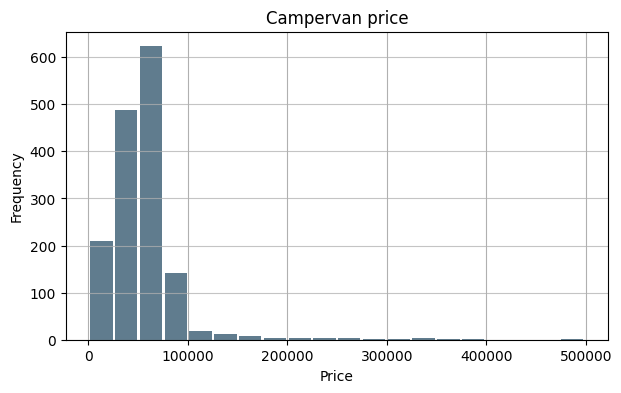

In [184]:
# Create a histogram
plt.figure(figsize=(7,4))
df.price.plot.hist(grid=True, 
                   bins=20, 
                   rwidth=0.9,
                   color='#607c8e')
plt.title('Campervan price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

## Close db connection (if open)

In [185]:
# Close db connection (if open)
try:
    if check_conn(conn):
        conn.close()
    else:
        pass
except:
    pass

# Status (True = open, False = closed)
print(check_conn(conn))

False


## Create additional variables from the campervan's descriptions

### Change strings in 'description_raw' ad 'text_raw' to uppercase 

In [186]:
# Change strings to uppercase 
df['description_raw'] = df['description_raw'].str.upper()
print(df['description_raw'].head(10), '\n')

df['location_raw'] = df['location_raw'].str.upper()
print(df['location_raw'].head(10))

0                                 MERCEDES-BENZ CAMPER
1        CARADO I 449 ÉDITION 15 FIAT CAPRON 169L/1449
2                                DETHLEFFS FIAT DUCATO
3                           FIAT EURO MASTER WOHNMOBIL
4    VW T6.1 CALIFORNIA 2.0 TDI OCEAN EDITION LIBER...
5    VW T6.1 KNAUS TOURER VAN 500 MW, MEGA AUSSTATT...
6             VW T6.1 CALIFORNIA 2.0 TDI OCEAN LIBERTY
7                                      HYMER BMC 580-I
8    VW T6 CALIFORNIA 2.0 TDI BULLI BEACH EDITION 4...
9             MERCEDES-BENZ MARCO POLO 250 D 7G-TRONIC
Name: description_raw, dtype: object 

0                   MITTELSTRASSE 38, 3613 STEFFISBURG
1    ZONE INDUSTRIELLE LES PORTETTES 2C, 1312 ECLÉPENS
2                   RTE DU ST-BERNARD 8, 1937 ORSIÈRES
3                    BADENERSTRASSE 84, 8952 SCHLIEREN
4                                       8852 ALTENDORF
5                                       8852 ALTENDORF
6                     GÜTERSTRASSE 37, 9444 DIEPOLDSAU
7                       BÜ

## Spannend wäre nach der Marke zu filtern, aber keine Ahnung wie

## Create new categorical variable for based on campervan price

In [187]:
# Define classes (labels)
labels = ['0 - 19999', '20000 - 49999', '50000 - 99999', '100000 - 199999', '200000 - 499999', '500000 - 999999']

# Use the .cut method from pandas to divide the numeric values in classes
df["price_cat"] = pd.cut(df['price'], bins=[0, 20000, 50000, 100000, 200000, 500000, 1000000], labels=labels)

# Show original data and classes
print(df[['price', 'price_cat']])

# Count the frequency of each class and sort them
df['price_cat'].value_counts().sort_index()

      price      price_cat
0     15900      0 - 19999
1     71900  50000 - 99999
2     37800  20000 - 49999
3     19900      0 - 19999
4     84500  50000 - 99999
...     ...            ...
1520  52900  50000 - 99999
1521  56900  50000 - 99999
1522  32777  20000 - 49999
1523  31777  20000 - 49999
1524  39777  20000 - 49999

[1525 rows x 2 columns]


price_cat
0 - 19999          143
20000 - 49999      553
50000 - 99999      766
100000 - 199999     42
200000 - 499999     21
500000 - 999999      0
Name: count, dtype: int64

### EDA

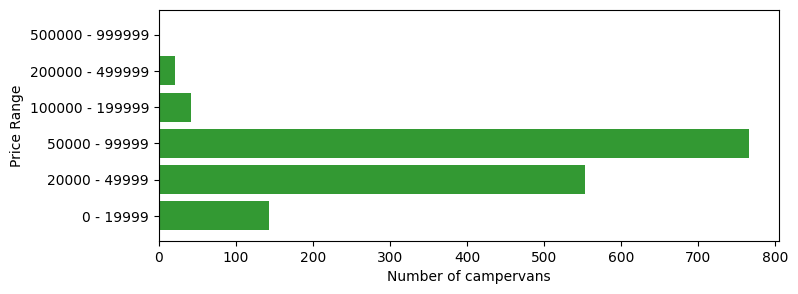

In [188]:
# Group data by rooms (only the topmost 15 values are shown)
df_bar = df['price_cat'].value_counts().nlargest(15).sort_index()

# Values for barchart
napart = list(df_bar.values)
index = list(df_bar.index.values)
y_pos = np.arange(len(index))

# Figure
fig, ax = plt.subplots(figsize=(8,3))
ax.barh(y_pos, napart, align='center', color='g', alpha=0.8)
ax.set_yticks(y_pos, index)
ax.set_xlabel('Number of campervans', fontsize=10)
ax.set_ylabel('Price Range', fontsize=10)

# Show graph
plt.show()